# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn import tree

from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [7]:
df = pd.read_csv('../data/checker_submits.csv')
df

,uid,labname,numTrials,timestamp
0,user_4,project1,1,2020-04-17 05:19:02.744528
1,user_4,project1,2,2020-04-17 05:22:45.549397
2,user_4,project1,3,2020-04-17 05:34:24.422370
3,user_4,project1,4,2020-04-17 05:43:27.773992
4,user_4,project1,5,2020-04-17 05:46:32.275104
...,...,...,...,...
1681,user_19,laba06s,9,2020-05-21 20:01:48.959966
1682,user_1,laba06s,6,2020-05-21 20:18:54.487900
1683,user_1,laba06s,7,2020-05-21 20:19:06.872761
1684,user_1,laba06s,8,2020-05-21 20:22:41.877806


In [8]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['dayofweek'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df.drop(['timestamp', 'date'], inplace=True, axis=1)
df

,uid,labname,numTrials,hour,dayofweek
0,user_4,project1,1,5,4
1,user_4,project1,2,5,4
2,user_4,project1,3,5,4
3,user_4,project1,4,5,4
4,user_4,project1,5,5,4
...,...,...,...,...,...
1681,user_19,laba06s,9,20,3
1682,user_1,laba06s,6,20,3
1683,user_1,laba06s,7,20,3
1684,user_1,laba06s,8,20,3


In [9]:
df = pd.get_dummies(df, prefix=['uid', 'labname'], columns=['uid', 'labname'])
df

,numTrials,hour,dayofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,...,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,1,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,9,20,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1682,6,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1683,7,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1684,8,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
scaler = StandardScaler()
df[['numTrials', 'hour']] = scaler.fit_transform(df[['numTrials', 'hour']])
df

,numTrials,hour,dayofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,...,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,-0.788667,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.756764,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.724861,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.692958,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.661055,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,-0.533442,0.945382,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1682,-0.629151,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1683,-0.597248,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1684,-0.565345,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
df.to_csv('../data/dayofweek.csv')

In [12]:
X = df.drop('dayofweek', axis=1)
y = df.dayofweek

In [13]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X, y)
y_dummy = dummy_clf.predict(X)
accuracy_score(y, y_dummy)

0.23487544483985764

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [14]:
logreg = LogisticRegression(fit_intercept=False, random_state=21)
logreg.fit(X, y)
y_logr = logreg.predict(X)
y_logr

array([4, 4, 4, ..., 3, 3, 3])

In [16]:
def draw_barh(w, columnsX, n):
   w_std = []
   for row in w:
      w_std.append(np.std(row))
   w_dict = dict(zip(columnsX, w_std))
   sort_w = {k: v for k, v in sorted(w_dict.items(), key=lambda item: item[1], reverse=True)}
   features = np.array(list(sort_w.keys()))[:n]
   weights = np.array(list(sort_w.values()))[:n]
   fig, ax = plt.subplots(figsize=(15, 8))
   plt.barh(np.arange(n), weights, color='xkcd:pale orange')
   ax.set_yticks(np.arange(n))
   ax.set_yticklabels(features)
   ax.invert_yaxis()
   plt.show()

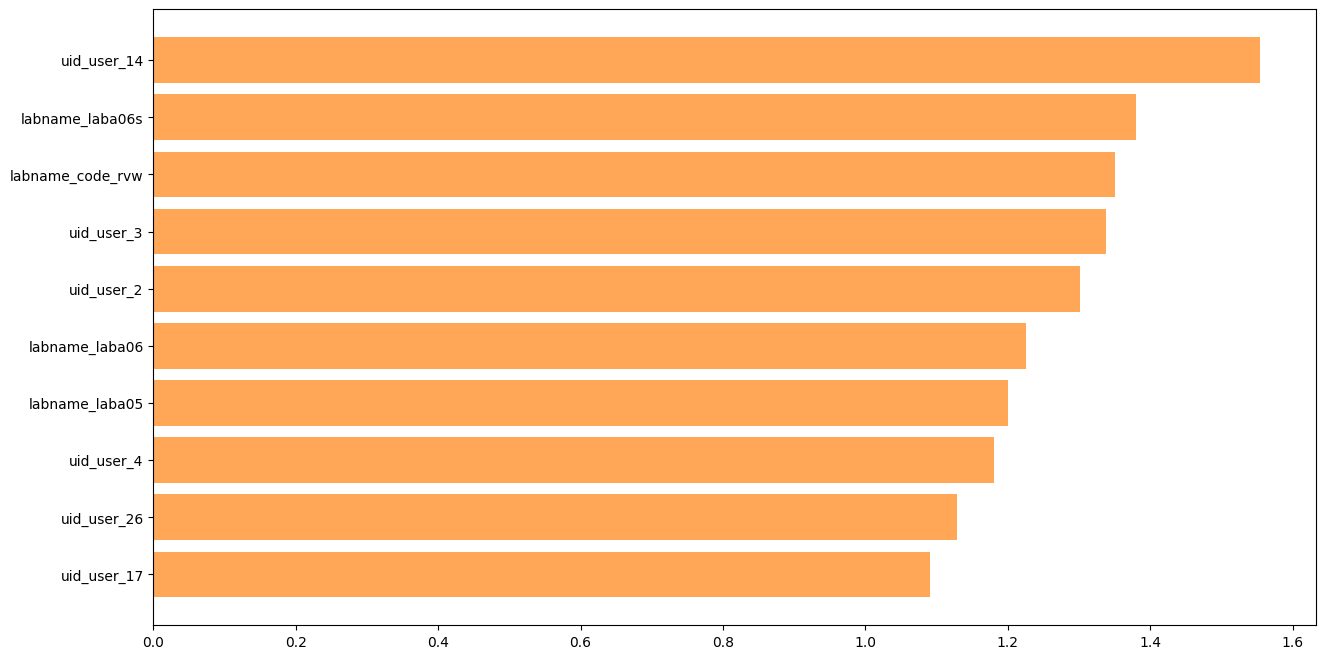

In [17]:
w = logreg.coef_.T
columnsX = X

draw_barh(w, columnsX, 10)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [18]:
X = df.drop('dayofweek', axis=1)
y = df.dayofweek

clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21)).fit(X,y)
y_svm = clf.predict(X)
y_svm

array([4, 4, 4, ..., 3, 3, 3])

In [19]:
accuracy_score(y, y_svm)

0.6126927639383155

/Users/hbrent/PythonDS/MINE/myenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


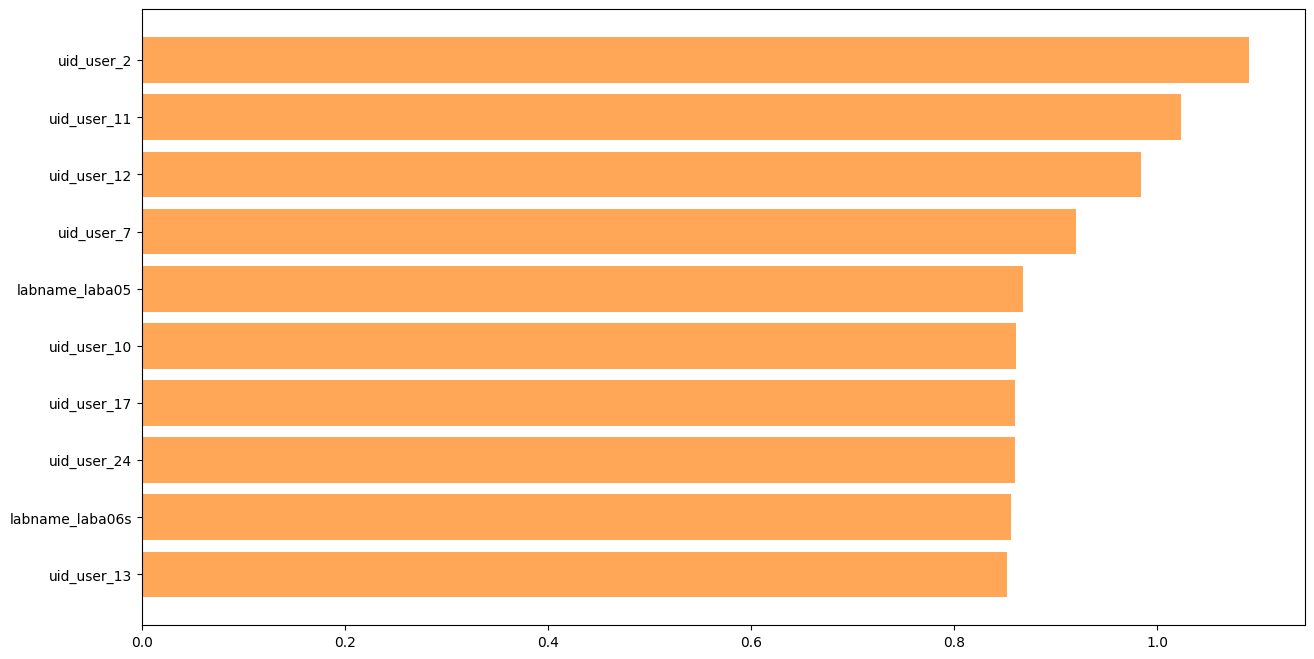

In [24]:
w = clf.coef_.T
columnsX = X

draw_barh(w, columnsX, 10)

In [26]:
def draw_barh(w, columnsX, n):
   w_dict = dict(zip(columnsX, w))
   sort_w = {k: v for k, v in sorted(w_dict.items(), key=lambda item: item[1], reverse=True)}
   features = np.array(list(sort_w.keys()))[:n]
   weights = np.array(list(sort_w.values()))[:n]
   fig, ax = plt.subplots(figsize=(15, 8))
   plt.barh(np.arange(n), weights, color='xkcd:pale orange')
   ax.set_yticks(np.arange(n))
   ax.set_yticklabels(features)
   ax.invert_yaxis()
   plt.show()

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [27]:
X = df.drop('dayofweek', axis=1)
y = df.dayofweek

parameters = {
    'max_depth': [4]
}
tD = tree.DecisionTreeClassifier(random_state=21)
clf1 = GridSearchCV(tD, parameters)
clf1 = clf1.fit(X, y)
y_tree = clf1.predict(X)
y_tree

array([3, 3, 3, ..., 3, 3, 3])

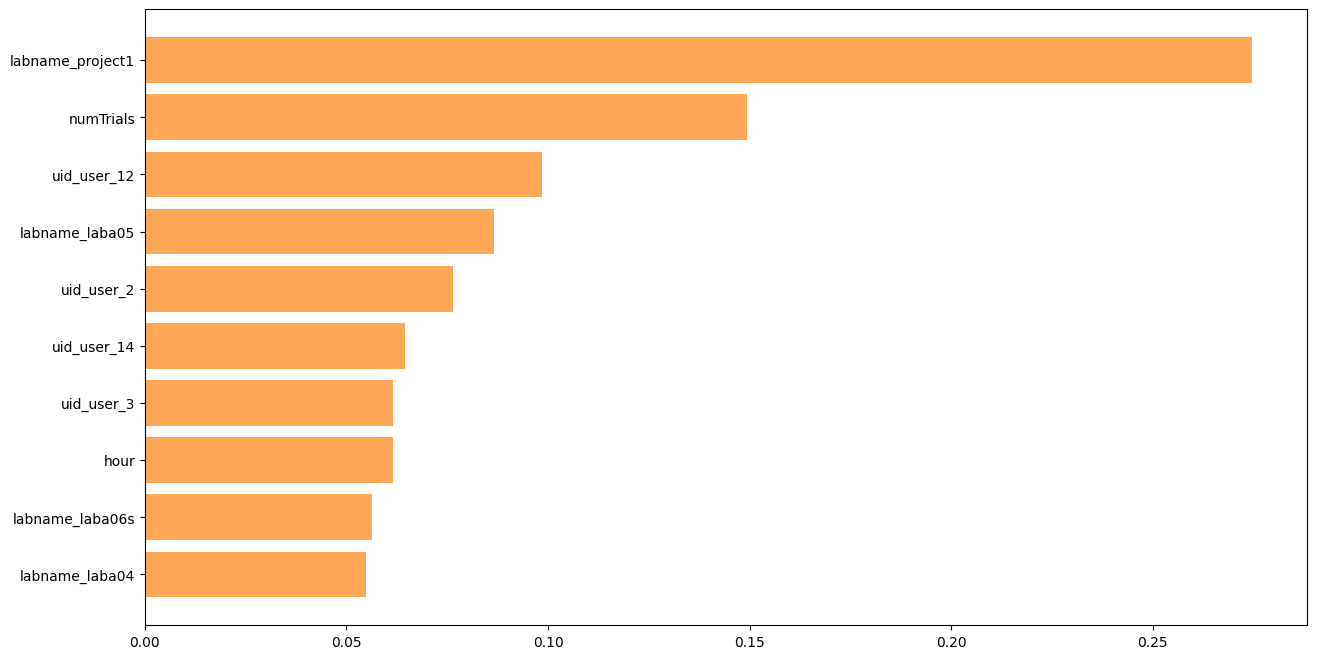

In [28]:
w = clf1.best_estimator_.feature_importances_
columnsX = X

draw_barh(w, columnsX, 10)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [29]:
random_forest_model = RandomForestClassifier(random_state=21)
param_grid = {'n_estimators': [100],
              'max_depth': [25]}
gs = GridSearchCV(random_forest_model, param_grid, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'max_depth': 25, 'n_estimators': 100}

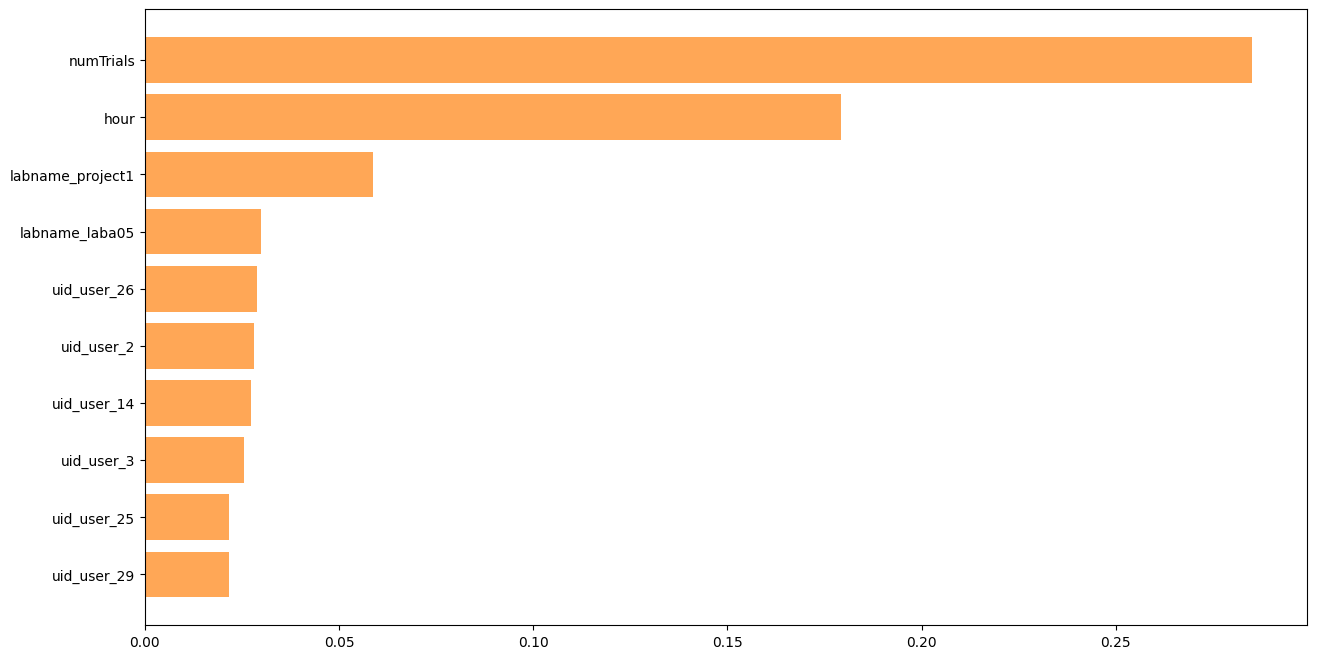

In [30]:
draw_barh(gs.best_estimator_.feature_importances_, X.columns, 10)